In [775]:
import matplotlib.font_manager
from IPython.core.display import HTML
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import random 
import csv
from IPython.display import display, Math
from numpy import unravel_index
from astropy.io import fits
from astropy.table import Table, vstack
import matplotlib.colors
from scipy.optimize import curve_fit
from matplotlib.colors import LinearSegmentedColormap

def make_html(fontname):
    return "<p>{font}: <span style='font-family:{font}; font-size: 24px;'>{font}</p>".format(font=fontname)

code = "\n".join([make_html(font) for font in sorted(set([f.name for f in matplotlib.font_manager.fontManager.ttflist]))])

HTML("<div style='column-count: 2;'>{}</div>".format(code))

plt.rcParams["font.family"] = "TeX Gyre Schola Math"

print("Quasar Systematics")

Quasar Systematics


In [272]:
#Define the colour map that we will use all along
cmap = LinearSegmentedColormap.from_list('truncated_bone', ['#000000', '#171720', '#676f87', '#8ba1ab', '#e8f0f0'], N=256)
cmap.set_bad(color='gray')

## Import the data

### Import the quasars from Gaia in a 7° radius around M31

In [282]:
hdu_list = fits.open('ThisIsTheData/Quasars/Quasars7_Deg.fits', memmap=True)
hdu_list.info()
evt_gaia = Table(hdu_list[1].data)
evt_gaia

Filename: ThisIsTheData/Quasars/Quasars7Deg.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      16   (845,)   uint8   
  1  /home/svalentin/Documents/S2/Code/Quasar/Gaia_EDR3_AGNs.csv    1 BinTableHDU     32   6400R x 10C   [D, D, E, E, E, E, E, E, E, E]   


RA_ICRS,DE_ICRS,Plx,e_Plx,PM,pmRA,e_pmRA,pmDE,e_pmDE,pmRApmDEcor
float64,float64,float32,float32,float32,float32,float32,float32,float32,float32
1.37673234579,41.29774226719,1.2628,1.681,1.083,0.584,1.593,0.913,1.179,-0.4456
1.41788327912,41.30492770004,0.1531,0.3487,0.225,-0.211,0.259,0.079,0.231,-0.0003
1.4210649213,40.57671415072,0.2694,0.3946,0.494,-0.207,0.282,-0.448,0.242,0.0267
1.4742929842,41.11657530713,0.0436,1.0255,1.503,-1.4,0.86,0.547,0.585,-0.1532
1.50473243085,42.18760386382,-0.0308,0.1946,0.113,0.05,0.173,0.101,0.147,-0.0571
1.50574447617,42.20149121184,-0.0174,1.3605,2.546,-0.966,1.26,2.355,1.967,0.1935
1.52686182294,41.60282805566,0.7368,1.1339,0.539,0.539,1.13,-0.018,0.864,-0.1849
1.53086323301,42.36484162084,-0.8524,1.2576,1.613,0.992,1.149,-1.272,1.077,-0.4074
1.54629034608,42.60736027317,0.5505,1.2625,1.143,-0.979,0.859,-0.591,0.786,-0.171


### Go to the ($\xi, \eta$) space

In [283]:
Delta = 41.27*np.pi/180

evt_gaia['RA_ICRS']  = (evt_gaia['RA_ICRS'] - 10.68)*np.cos(Delta)
evt_gaia['DE_ICRS'] = (evt_gaia['DE_ICRS'] - 41.27)

### Import the data from the model (purely aesthetic)

In [284]:
def OutCVSModel(name):
    #___ Description_____________________________________________________________________________________
    #Arguments:: name of the file to be read
    #Returns:: list of lists with either all the velocity components as seen from Earth, or  with all the 
    #         positions of the ellipse for the model
    #____________________________________________________________________________________________________
  
    LIST1, LIST2, LIST3 = [], [], []
    if name != "model":
        with open('ThisIsTheData/' + name + '.csv', 'r') as file:
            reader = csv.reader(file)
            for row in reader:
                LIST1.append([float(row[0]), float(row[1])])
        return LIST1
    
    else:
        with open('ThisIsTheData/' + name + '.csv', 'r') as file:
            reader = csv.reader(file)
            for row in reader:
                LIST1.append(float(row[0]))
                LIST2.append(float(row[1]))
                LIST3.append(-float(row[2]))
        return LIST1, LIST2, LIST3        

In [285]:
#Reading the cvs files
x_model, y_model, z_model = OutCVSModel("model")

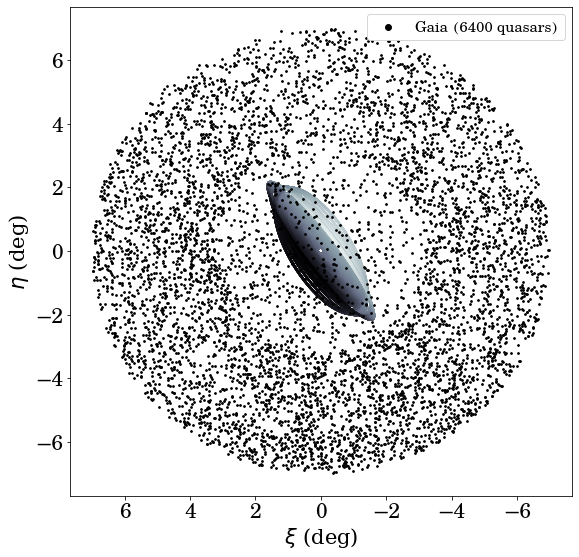

In [286]:
plt.figure(figsize=(9, 9))
#Plot the background:
plt.scatter(x_model, y_model, c=z_model, cmap=cmap, s=1, linewidth=0)
plt.scatter(evt_gaia['RA_ICRS'], evt_gaia['DE_ICRS'], c='black', s=3, 
            label=f"Gaia ({len(evt_gaia['RA_ICRS'])} quasars)") #880808

plt.xlabel(r'$\xi$ (deg)', fontname = 'Serif', size = 21)
plt.ylabel(r'$\eta$ (deg)', fontname = 'Serif', size = 21)
lgnd = plt.legend(loc="upper right", scatterpoints=1, fontsize=15)
lgnd.legendHandles[0]._sizes = [35]
plt.xticks(fontsize = 21)
plt.yticks(fontsize = 21)
plt.gca().invert_xaxis()
#plt.savefig('Superimposed.png', dpi=500)
plt.show()

### Selection of the different regions

In [287]:
def ElContaminant(RA, DEC, Num): 
    #___ Description_____________________________________________________________________________________
    #Arguments:: This function basically is a simplified function than the one found from 'CleaningCuts' 
    #           It separates the space in 4 quadrant here being N(Num=1), S(Num=2), E(Num=3), W(Num=0). 
    #           RA and DEC position of objects.
    #Returns:: returns either true or false if the object is in one of the four quadrant or not
    #____________________________________________________________________________________________________
    Ra, Dec = np.array(RA), np.array(DEC)
    Result = []
    
    Sign = [[1, 1], [1, -1], [-1, 1], [-1, -1]]
    
    PA     = 45*np.pi/180 #radians, position angle
    
    AngDia2 = 9 #degrees, inclination angle
    A     = AngDia2
    B     = AngDia2
    
    R_rot = np.array([[np.cos(PA), -np.sin(PA)], [np.sin(PA), np.cos(PA)]])
    
    for i in range(len(Ra)):
        Ell_rot = np.dot(R_rot, [Ra[i], Dec[i]])
        if (Ell_rot[0]**2)/(A**2) + (Ell_rot[1]**2)/(B**2) <= 1: #Keeps every stars in the big ellipse
            if Sign[Num][0]*Ell_rot[0]*np.cos(PA) < 0 and Sign[Num][1]*Ell_rot[1]*np.sin(PA) < 0: #Linear selection along lines
                Result.append(True)
            else: 
                Result.append(False)
        else: 
            Result.append(False)

    return Result

In [798]:
def Quadrant(evt_data, Number):
    #___ Description_____________________________________________________________________________________
    #Arguments:: Astropy table in which we find RA and DEC coordinates and a number (see ElContaminant)
    #Returns:: list of the coordinates in the choosen quadrant and also the corresponding pm...
    #____________________________________________________________________________________________________
    mask = (np.array(ElContaminant(evt_data['RA_ICRS'], evt_data['DE_ICRS'], Number)) == True)
    
    return evt_data[mask]['RA_ICRS'], evt_data[mask]['DE_ICRS'], evt_data[mask]['pmRA'], evt_data[mask]['e_pmRA'], evt_data[mask]['pmDE'], evt_data[mask]['e_pmDE'], evt_data[mask]['pmRApmDEcor']

In [289]:
RaDec1 = Quadrant(evt_gaia, 0)
RaDec2 = Quadrant(evt_gaia, 1)
RaDec3 = Quadrant(evt_gaia, 2)
RaDec4 = Quadrant(evt_gaia, 3)

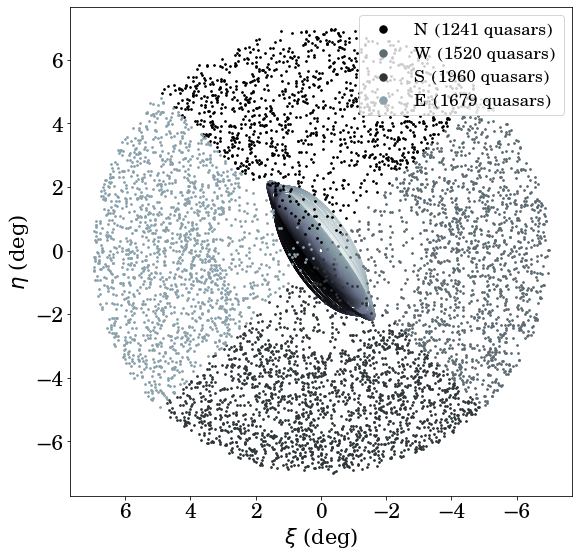

In [290]:
plt.figure(figsize=(9, 9))
plt.scatter(x_model, y_model, c=z_model, cmap=cmap, s=1, linewidth=0)
plt.scatter((RaDec2[0]), (RaDec2[1]), s=3, color='#000000', label=f"N ({len(RaDec2[0])} quasars)")
plt.scatter((RaDec1[0]), (RaDec1[1]), s=3, color='#5D6B72', label=f"W ({len(RaDec1[0])} quasars)")
plt.scatter((RaDec3[0]), (RaDec3[1]), s=3, color='#2E3639', label=f"S ({len(RaDec3[0])} quasars)")
plt.scatter((RaDec4[0]), (RaDec4[1]), s=3, color='#8BA1AB', label=f"E ({len(RaDec4[0])} quasars)")
plt.xlabel(r'$\xi$ (deg)', fontname = 'Serif', size = 21)
plt.ylabel(r'$\eta$ (deg)', fontname = 'Serif', size = 21)
plt.xticks(fontsize = 21)
plt.yticks(fontsize = 21)
plt.gca().invert_xaxis()
lgnd = plt.legend(loc="upper right", scatterpoints=1, fontsize=17)
lgnd.legendHandles[0]._sizes = [55]
lgnd.legendHandles[1]._sizes = [55]
lgnd.legendHandles[2]._sizes = [55]
lgnd.legendHandles[3]._sizes = [55]
plt.show()

### Determine the systematics in each quadrants

Careful, for some reasons that I still can't entirely understand, when saving and returning on the program, all the cells after the cython cells are automatically being deleted. So in order to prevent that, I had to put the cython cells at the end of the program. This is a little annoying because we have first to go at the end to excecute it, but it is necessary.

In [291]:
class LikelihooD():
    #____Constructor::___________________________________________________________________________________
    def __init__(self, NbModels, GaiaData):
        self.NbModels = NbModels
        
        self.mu_ra      = GaiaData[2]*1000 #convert the proper motions in µas/yr
        self.mu_ra_sig  = GaiaData[3]*1000
        self.mu_dec     = GaiaData[4]*1000
        self.mu_dec_sig = GaiaData[5]*1000
        self.corr       = GaiaData[6]
           
    #____Methods::_______________________________________________________________________________________
    def Execute(self):
        #Let's first execute the command that will create the lists of free parameters (f.p.)
        self.FreeParameters()
        
        #Create the function that will contain the values of the likelihood for a given f.p. couple                     
        self.LikelihoodList = np.zeros((len(self.pm_ra_quasars), len(self.pm_dec_quasars)))
        for i in range(len(self.pm_dec_quasars)):
            for j in range(len(self.pm_ra_quasars)):
                for k in range(len(self.mu_ra)):
                    self.LikelihoodList[j,i] += LikelihoodCFunctionCorr(self.pm_ra_quasars[i], self.pm_dec_quasars[j], 
                                                                    self.mu_ra_sig[k], self.mu_dec_sig[k], 
                                                                    self.mu_ra[k], self.mu_dec[k], self.corr[k])

        self.Renormalisation()  
    
        self.OneDimGaussian()
    
        self.Plot()
            
        return self.ra_max, self.dec_max, self.x_bins, self.y_gaus, self.popt_ra
                
    def FreeParameters(self):
        self.pm_ra_quasars  = np.linspace(-50, 50, self.NbModels) 
        self.pm_dec_quasars = np.linspace(-50, 50, self.NbModels)
        
        self.space = self.pm_ra_quasars[-1] - self.pm_ra_quasars[-2]
    
    def Renormalisation(self):
        max_likeli = np.max(self.LikelihoodList)
        for i in range(len(self.pm_dec_quasars)):
            for j in range(len(self.pm_ra_quasars)):
                self.LikelihoodList[j,i] -= max_likeli
                self.LikelihoodList[j,i] = np.exp(self.LikelihoodList[j,i])
        
        ra_max, dec_max = unravel_index(self.LikelihoodList.argmax(), self.LikelihoodList.shape)
        
        self.ra_max, self.dec_max = self.pm_ra_quasars[dec_max], self.pm_dec_quasars[ra_max]
        
    def OneDimGaussian(self):
        self.x_gaus, self.y_gaus = [], []
        for i in range(self.NbModels):
            line = self.LikelihoodList[i, :]
            self.x_gaus.append(np.sum(line))
            
            row = self.LikelihoodList[: ,i]
            self.y_gaus.append((np.sum(row)))
            
        sum_x = sum(self.x_gaus)
        x_gaus = [x / sum_x for x in self.x_gaus]

        sum_y = sum(self.y_gaus)
        y_gaus = [y / sum_y for y in self.y_gaus]

        self.index_centre_x = x_gaus.index(max(x_gaus))
        self.index_centre_y = y_gaus.index(max(y_gaus))

        sum_x, sum_y = x_gaus[self.index_centre_x], y_gaus[self.index_centre_y]
        
        self.index_border_x = 0
        while sum_x < 0.683:
            self.index_border_x += 1
            sum_x += x_gaus[self.index_centre_x + self.index_border_x]
            sum_x += x_gaus[self.index_centre_x - self.index_border_x]
            
        self.index_border_y = 0
        while sum_y < 0.683:
            self.index_border_y += 1
            sum_y += y_gaus[self.index_centre_y + self.index_border_y]
            sum_y += y_gaus[self.index_centre_y - self.index_border_y]
            
        print('Uncertainties in x: ', self.index_border_y*self.space)    
        print('Uncertainties in y: ', self.index_border_x*self.space)
        
    def Uncertainties(self, x_axis, y_axis):
        def gaussian(x, a, x0, sigma):
            return a * np.exp(-(x - x0)**2 / (2 * sigma**2))
        
        popt, pcov = curve_fit(gaussian, x_axis, y_axis)
        
        return popt
                
    def Plot(self):
        def scatter_hist(ax, ax_histx, ax_histy):
            ax_histx.tick_params(axis="x", labelsize=15, labelbottom=False) 
            ax_histy.tick_params(axis="y", labelleft=False, labelsize=15)
            
            ax.contour(self.pm_ra_quasars, self.pm_dec_quasars, self.LikelihoodList, 
                    levels=[np.exp(-0.5*11.8), np.exp(-0.5*6.17), np.exp(-0.5*2.3)],  
                    #colors=['#ff6200', 'darkred', 'black'])
                    colors=['#8FACB9', '#56676F', '#000000'])
            ax.scatter(self.ra_max, self.dec_max, c="#f6b515")
            ax.tick_params(axis='both', which='major', labelsize=15)
            ax.set_xlabel(r'$\mu_{\alpha, quasars}$ ($\mu$as.yr$^{-1})$', fontname = 'Serif', size = 19)
            ax.set_ylabel(r'$\mu_{\delta, quasars}$ ($\mu$as.yr$^{-1})$', fontname = 'Serif', size = 19)
            ax.grid(ls = ":")
            
            ax.set_xlim(ax.get_xlim()[::-1])

            self.x_bins, self.y_bins = [], [] 
            for i in range(len(self.pm_dec_quasars)):
                self.x_bins.append(self.pm_ra_quasars[i] - self.space/2)
            for i in range(len(self.pm_ra_quasars)):
                self.y_bins.append(self.pm_dec_quasars[i] - self.space/2)
            
            #Plot of the RA histogram
            ax_histx.grid(ls = ":")
            ax_histx.bar(self.x_bins, self.y_gaus, width=self.space, align='edge', edgecolor='black',
                         color='#646b84', alpha=0.8, zorder=3)
            ax_histx.set_yticklabels([])
            self.popt_ra = self.Uncertainties(self.x_bins, self.y_gaus) #deduction std
            
            #Plot of the DEC histogram
            ax_histy.barh(self.y_bins, self.x_gaus, height=self.space, align='edge', edgecolor='black',
                          color='#646b84', alpha=0.8, zorder=3)
            ax_histy.grid(ls = ":", zorder=3)
            ax_histy.set_xticklabels([])
            self.popt_dec = self.Uncertainties(self.y_bins, self.x_gaus) #deduction std
        
        fig = plt.figure(figsize=(9, 9))
        gs = fig.add_gridspec(2, 2, width_ratios=(4, 1), height_ratios=(1, 4),
                              left=0.1, right=0.9, bottom=0.1, top=0.9,
                              wspace=0.05, hspace=0.05)

        ax = fig.add_subplot(gs[1, 0])
        ax_histx = fig.add_subplot(gs[0, 0], sharex=ax)
        ax_histy = fig.add_subplot(gs[1, 1], sharey=ax)

        scatter_hist(ax, ax_histx, ax_histy)
        
        #Because of how I build the array the dec actually corresponds to the ra and vice versa 
        print("Maximum of likelihood:")
        display(Math(r"\mu_{\alpha, quasars} = " + str(round(self.ra_max, 1)) + "\pm" + str(
            round(self.popt_ra[2], 1)) + r"\ \mu as/yr"))
        display(Math(r"\mu_{\delta, quasars} = " + str(round(self.dec_max, 1)) + "\pm" + str(
            round(self.popt_dec[2], 1))  + r"\ \mu as/yr"))

Uncertainties in x:  5.909090909090892
Uncertainties in y:  5.454545454545439
Maximum of likelihood:


<IPython.core.display.Math object>

<IPython.core.display.Math object>

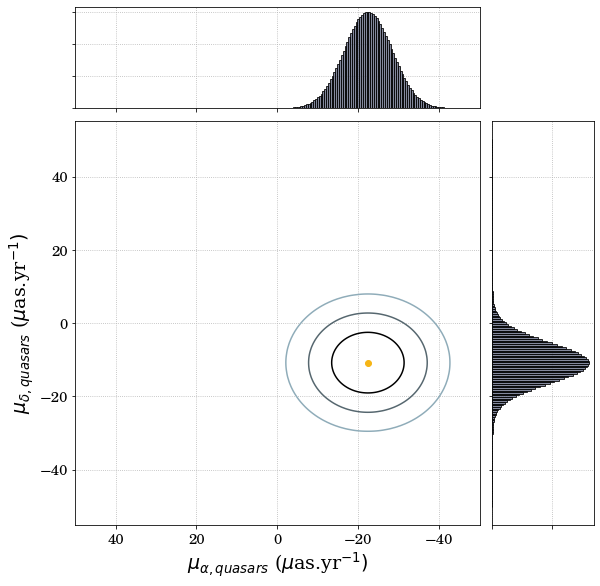

In [292]:
#Western quadrant::
ObjLike = LikelihooD(221, RaDec1)
Answer  = ObjLike.Execute()

Uncertainties in x:  5.909090909090892
Uncertainties in y:  5.909090909090892
Maximum of likelihood:


<IPython.core.display.Math object>

<IPython.core.display.Math object>

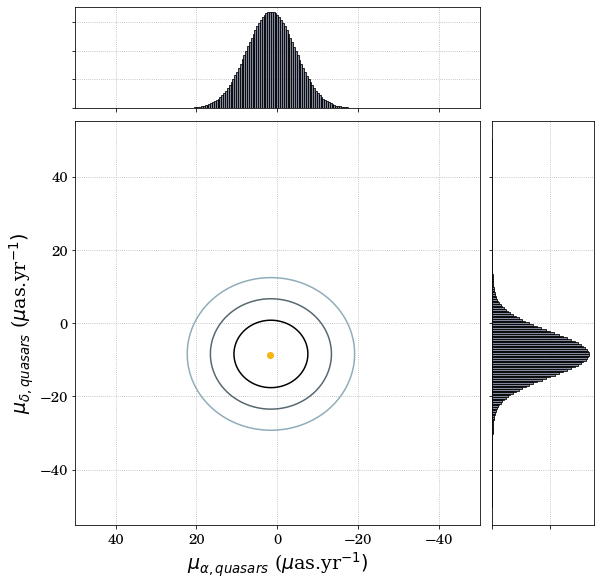

In [293]:
#Northern quadrant::
ObjLike = LikelihooD(221, RaDec2)
Answer  = ObjLike.Execute()

Uncertainties in x:  8.636363636363612
Uncertainties in y:  5.454545454545439
Maximum of likelihood:


<IPython.core.display.Math object>

<IPython.core.display.Math object>

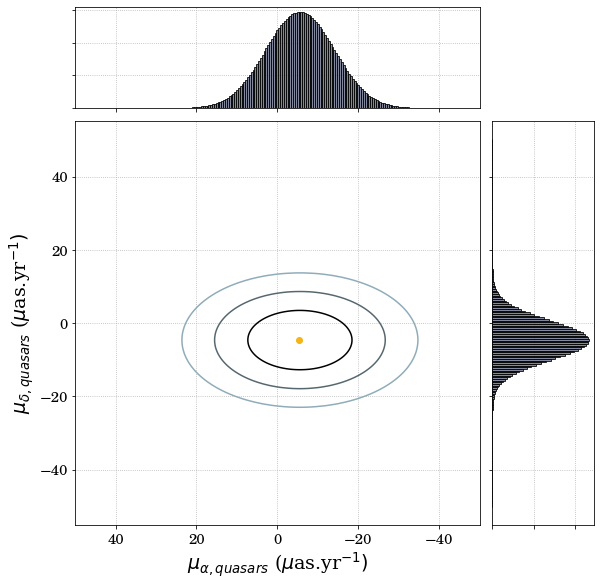

In [294]:
#Southern quadrant::
ObjLike = LikelihooD(221, RaDec3)
Answer  = ObjLike.Execute()

Uncertainties in x:  7.727272727272705
Uncertainties in y:  5.454545454545439
Maximum of likelihood:


<IPython.core.display.Math object>

<IPython.core.display.Math object>

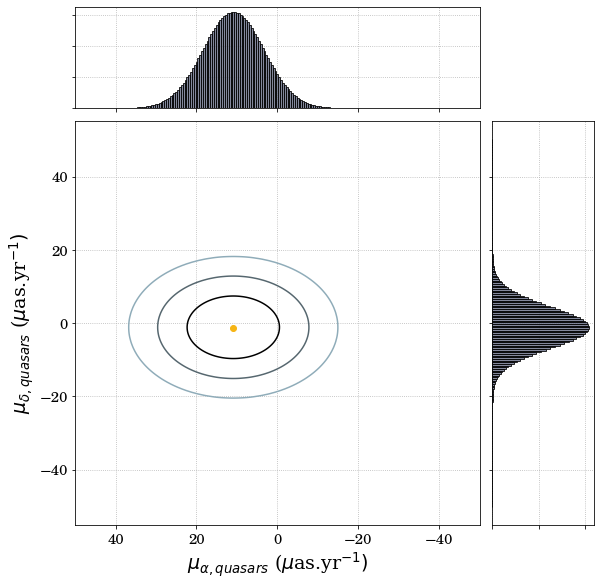

In [295]:
#Eastern quadrant::
ObjLike = LikelihooD(221, RaDec4)
Answer  = ObjLike.Execute()

### Quick example of the fitting method, to see if it works or not:

In [206]:
def plot_gaussian_fit(x_axis, y_axis, popt):
    # Plot the histogram
    fig, ax = plt.subplots(figsize=(7, 4))
    ax.bar(x_axis, y_axis, width=x_axis[1]-x_axis[0], align='edge', edgecolor='black',
           color='#646b84', alpha=0.8)
    ax.set_xlabel(r'$\mu_{\alpha, quasars}$ ($\mu$as.yr$^{-1})$', fontsize=15)
    ax.set_ylabel('Occurences', fontsize=15)

    # Plot the Gaussian fit
    x_fit = np.linspace(min(x_axis), max(x_axis), 1000)
    y_fit = gaussian(x_fit, *popt)
    ax.plot(x_fit, y_fit, 'k--', label='Gaussian fit')
    
    # Calculate the height at 1 sigma
    x_1sigma = np.array([popt[1] - popt[2], popt[1] + popt[2]])
    y_1sigma = gaussian(x_1sigma, *popt)
    
    # Plot 1-sigma bounds
    sigma = popt[2]
    x_low, x_high = popt[1] - sigma, popt[1] + sigma
    y_max = y_fit.max()
    ax.plot([x_low, x_low], [0, y_max], 'k--', linewidth=2)
    ax.plot([x_high, x_high], [0, y_max], 'k--', linewidth=2)
    ax.annotate("", xy=(x_high, y_1sigma[0]), xytext=(x_low, y_1sigma[0]), arrowprops=dict(arrowstyle='<->', color='black', linewidth=2))
    ax.text(popt[1]-2, y_max/2, r'1$\sigma$', color='black', 
        bbox=dict(facecolor='white', alpha=0.9, edgecolor='black', boxstyle='round,pad=0.7'), fontname = 'Serif', size = 11)
    
    # Set axis tick labels font size
    ax.xaxis.set_tick_params(labelsize=15)
    ax.yaxis.set_tick_params(labelsize=15)

    # Set legend position
    ax.legend(loc='upper left', fontsize=12)

    plt.show()

def gaussian(x, a, x0, sigma):
    return a * np.exp(-(x - x0)**2 / (2 * sigma**2))

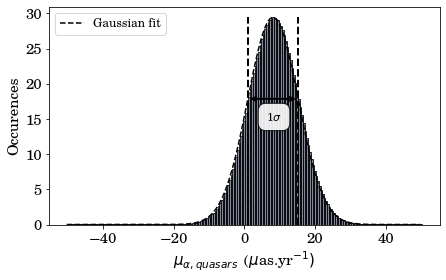

In [207]:
plot_gaussian_fit(Answer[2], Answer[3], Answer[4])

# PS1 Catalogue

## All the objects

In this section we will first visualise all the objects present in the PS1 catalogue and in a radius of 7° around M31 without taking into account any condition on the probability of the object to be a QSO or not.

In [845]:
hdu_list = fits.open('ThisIsTheData/Quasars/PS1_7Deg.fits', memmap=True)
hdu_list.info()
evt_PS1 = Table(hdu_list[1].data)

Delta = 41.27*np.pi/180

evt_PS1['RAdeg']  = (evt_PS1['RAdeg'] - 10.68)*np.cos(Delta)
evt_PS1['DECdeg'] = (evt_PS1['DECdeg'] - 41.27)

Filename: ThisIsTheData/Quasars/PS1_7Deg.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      16   (596,)   uint8   
  1  /home/svalentin/Documents/S2/Code/Quasar/NH_qso_rrlyrae_candidate...    1 BinTableHDU     18   302967R x 3C   [D, D, E]   


Then we would like to know how many of those quasars have a probability above 50% of being a quasar. To do so we can do a simple mask directly using Astropy.

In [846]:
maskProba = (evt_PS1['p_QSO'] > 0.5)

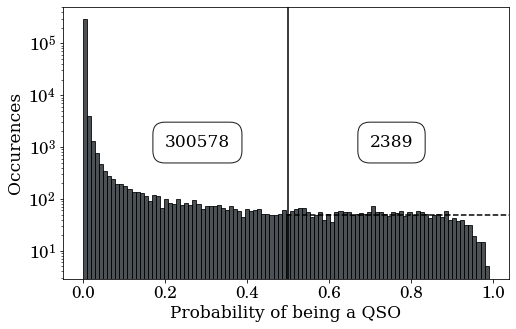

In [847]:
plt.figure(figsize=(8, 5))
#Proper histogram
hist_PS1_obj, bins_PS1_obj, patches_PS1_obj = plt.hist(evt_PS1['p_QSO'], bins=100, 
                                                       edgecolor='black', color='#1E2629', alpha=0.8)

#Determination of the average above a probability of 0.5
index_lower_PS1_obj = np.where(bins_PS1_obj > 0.5)[0][0]
mean_PS1_obj        = np.mean(hist_PS1_obj[index_lower_PS1_obj:])
plt.axhline(y = mean_PS1_obj, color = 'black', linestyle = '--', xmin = 0.5, xmax = 1)
plt.axvline(x = 0.5, color = 'black', label = 'axvline - full height')

#Other details
plt.yscale('log')
plt.xlabel(r'Probability of being a QSO', fontname = 'Serif', size = 17)
plt.ylabel(r'Occurences', fontname = 'Serif', size = 17)
plt.text(0.2, 1000, f"{len(evt_PS1['RAdeg']) - len(evt_PS1[maskProba]['RAdeg'])}", color='black', 
        bbox=dict(facecolor='white', alpha=0.9, edgecolor='black', boxstyle='round,pad=0.7'), fontname = 'Serif', size = 17)
plt.text(0.7, 1000, f"{len(evt_PS1[maskProba]['RAdeg'])}", color='black', 
        bbox=dict(facecolor='white', alpha=0.9, edgecolor='black', boxstyle='round,pad=0.7'), fontname = 'Serif', size = 17)
plt.xticks(fontsize = 17)
plt.yticks(fontsize = 17)
plt.show()

In [848]:
print('The mean value of the occurences above 0.5 is:', round(mean_PS1_obj, 2))

The mean value of the occurences above 0.5 is: 48.41


Just as a reminder, those were the QSOs from the PS1 catalogue only. Now what we would like to do is to cross-match the QSOs that were used for the Gaia reference frame to objects in PS1 and see what are their probability distribution of being QSOs.

In [849]:
hdu_list = fits.open('ThisIsTheData/Quasars/GaiaQSO_X_PS1.fits', memmap=True)
hdu_list.info()
evt_QSO_X_PS1 = Table(hdu_list[1].data)

Delta = 41.27*np.pi/180

evt_QSO_X_PS1['RAdeg']  = (evt_QSO_X_PS1['RAdeg'] - 10.68)*np.cos(Delta)
evt_QSO_X_PS1['DECdeg'] = (evt_QSO_X_PS1['DECdeg'] - 41.27)

Filename: ThisIsTheData/Quasars/GaiaQSO_X_PS1.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      16   (2702,)   uint8   
  1  Joined        1 BinTableHDU     43   4350R x 14C   [D, D, E, E, E, E, E, E, E, E, D, D, E, D]   


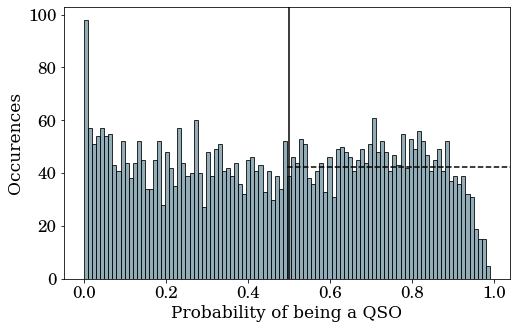

In [850]:
plt.figure(figsize=(8, 5))
hist_Gaia_obj, bins_Gaia_obj, patches_Gaia_obj = plt.hist(evt_QSO_X_PS1['p_QSO'], bins=100, 
                                                          edgecolor='black', color='#7799A5', alpha=0.8)

#Determination of the average above a probability of 0.5
index_lower_Gaia_obj = np.where(bins_Gaia_obj > 0.5)[0][0]
mean_Gaia_obj        = np.mean(hist_Gaia_obj[index_lower_Gaia_obj:])
plt.axhline(y = mean_Gaia_obj, color = 'black', linestyle = '--', xmin = 0.5, xmax = 1)
plt.axvline(x = 0.5, color = 'black', linestyle = '-')

plt.xlabel(r'Probability of being a QSO', fontname = 'Serif', size = 17)
plt.ylabel(r'Occurences', fontname = 'Serif', size = 17)
plt.xticks(fontsize = 17)
plt.yticks(fontsize = 17)
plt.show()

In [851]:
print('The mean value of the occurences above 0.5 is:', round(mean_Gaia_obj, 2))

The mean value of the occurences above 0.5 is: 42.37


We see that contrary to the previous case, this time the distribution of probabilities seems to e quite uniform.

### Renormalisation to superimpose them

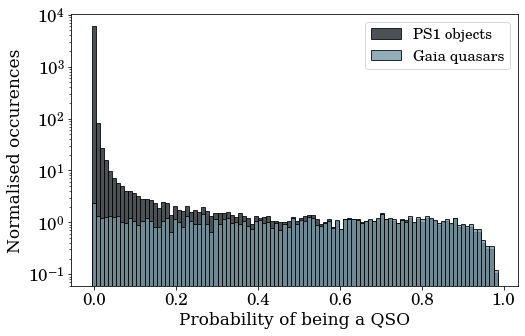

In [852]:
plt.figure(figsize=(8, 5))
Normalised_PS1  = hist_PS1_obj/mean_PS1_obj
Normalised_Gaia = hist_Gaia_obj/mean_Gaia_obj

for i in range(len(bins_Gaia_obj) - 1):
    if i == 1:
        plt.bar(bins_PS1_obj[i], Normalised_PS1[i], width=bins_PS1_obj[1]-bins_PS1_obj[0], edgecolor='black',
                              color='#1E2629', alpha=0.8, label='PS1 objects')
        plt.bar(bins_PS1_obj[i], Normalised_Gaia[i], width=bins_PS1_obj[1]-bins_PS1_obj[0], edgecolor='black',
                              color='#7799A5', alpha=0.8, label='Gaia quasars')
    else:
        plt.bar(bins_PS1_obj[i], Normalised_PS1[i], width=bins_PS1_obj[1]-bins_PS1_obj[0], edgecolor='black',
                        color='#1E2629', alpha=0.8)
        plt.bar(bins_PS1_obj[i], Normalised_Gaia[i], width=bins_PS1_obj[1]-bins_PS1_obj[0], edgecolor='black',
                        color='#7799A5', alpha=0.8)

plt.yscale('log')
plt.xlabel(r'Probability of being a QSO', fontname = 'Serif', size = 17)
plt.ylabel(r'Normalised occurences', fontname = 'Serif', size = 17)
lgnd = plt.legend(loc="upper right", scatterpoints=1, fontsize=15)
plt.xticks(fontsize = 17)
plt.yticks(fontsize = 17)
plt.show()

In [853]:
Ratios_PS1_Over_Gaia = []

#Creates the list of the ratios
for i in range(len(Normalised_PS1)):
    Ratios_PS1_Over_Gaia.append(Normalised_PS1[i]/Normalised_Gaia[i])

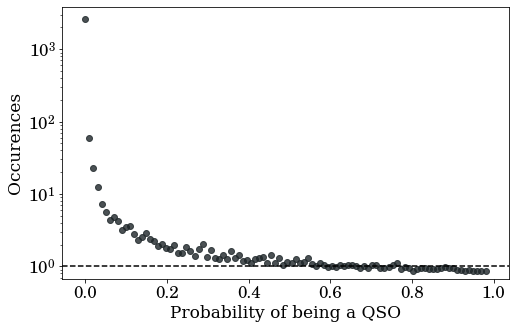

In [854]:
plt.figure(figsize=(8, 5))
for i in range(len(bins_Gaia_obj) - 1):
    plt.scatter(bins_PS1_obj[i], Ratios_PS1_Over_Gaia[i], color='#1E2629', alpha=0.8)
    
plt.axhline(y = 1, color = 'black', linestyle = '--')

plt.yscale('log')
plt.xlabel(r'Probability of being a QSO', fontname = 'Serif', size = 17)
plt.ylabel(r'Occurences', fontname = 'Serif', size = 17)
plt.xticks(fontsize = 17)
plt.yticks(fontsize = 17)
plt.show()

On the two last graphs we see that the distributions really seem to change when going to probabilities below 0.4. Hence, this will be the value that we are going to use. Now that we have found this value let's do again the first histogram but this time using the new probability.

In [905]:
maskProbaUpdated = (evt_PS1['p_QSO'] >= 0.4)

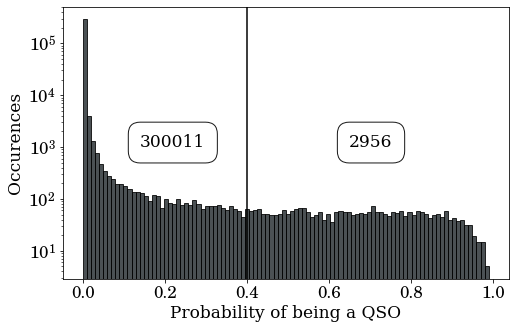

In [906]:
plt.figure(figsize=(8, 5))
#Proper histogram
hist_PS1_obj, bins_PS1_obj, patches_PS1_obj = plt.hist(evt_PS1['p_QSO'], bins=100, 
                                                       edgecolor='black', color='#1E2629', alpha=0.8)
plt.axvline(x = 0.4, color = 'black', label = 'axvline - full height')

#Other details
plt.yscale('log')
plt.xlabel(r'Probability of being a QSO', fontname = 'Serif', size = 17)
plt.ylabel(r'Occurences', fontname = 'Serif', size = 17)
plt.text(0.14, 1000, f"{len(evt_PS1['RAdeg']) - len(evt_PS1[maskProbaUpdated]['RAdeg'])}", color='black', 
        bbox=dict(facecolor='white', alpha=0.9, edgecolor='black', boxstyle='round,pad=0.7'), fontname = 'Serif', size = 17)
plt.text(0.65, 1000, f"{len(evt_PS1[maskProbaUpdated]['RAdeg'])}", color='black', 
        bbox=dict(facecolor='white', alpha=0.9, edgecolor='black', boxstyle='round,pad=0.7'), fontname = 'Serif', size = 17)
plt.xticks(fontsize = 17)
plt.yticks(fontsize = 17)
plt.show()

Doing so we have been able to increase by 567 the number of QSOs that we are going to use.

### Plot of the quasars

Now we would like to see if adding this sample actually improves the sky coverage. Just to be perfectly clear:

- The Gaia quasars are the quasars from Gaia that we have been able to cross match with PS1 sources
- The PS1 quasars are the variable objects for the PS1 catalogue which are identified as having a probability of being a quasar superior to 0.4.

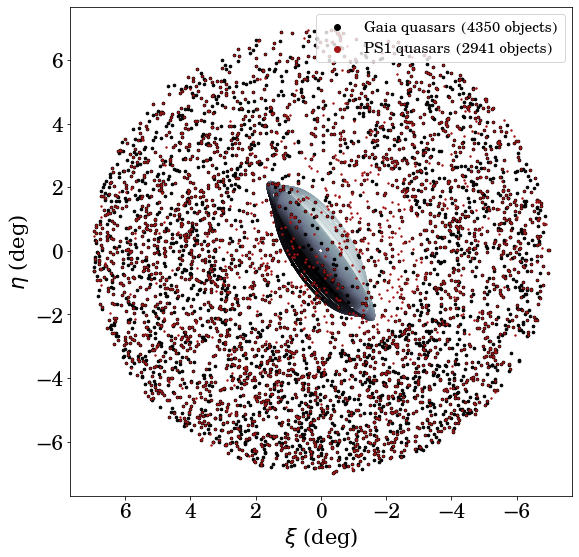

In [859]:
plt.figure(figsize=(9, 9))
#Plot the background:
plt.scatter(x_model, y_model, c=z_model, cmap=cmap, s=1, linewidth=0)

plt.scatter(evt_QSO_X_PS1['RAdeg'], evt_QSO_X_PS1['DECdeg'], c='#000000', 
            s=7, label=f"Gaia quasars ({len(evt_QSO_X_PS1['RAdeg'])} objects)")

plt.scatter(evt_PS1[maskProbaUpdated]['RAdeg'], evt_PS1[maskProbaUpdated]['DECdeg'], c='#A31515', 
            s=2, label=f"PS1 quasars ({len(evt_PS1[maskProbaUpdated]['RAdeg'])} objects)")

plt.xlabel(r'$\xi$ (deg)', fontname = 'Serif', size = 21)
plt.ylabel(r'$\eta$ (deg)', fontname = 'Serif', size = 21)
plt.xticks(fontsize = 21)
plt.yticks(fontsize = 21)
plt.gca().invert_xaxis()
lgnd = plt.legend(loc="upper right", scatterpoints=1, fontsize=15)
lgnd.legendHandles[0]._sizes = [35]
lgnd.legendHandles[1]._sizes = [35]
#plt.savefig('Superimposed.png', dpi=500)
plt.show()

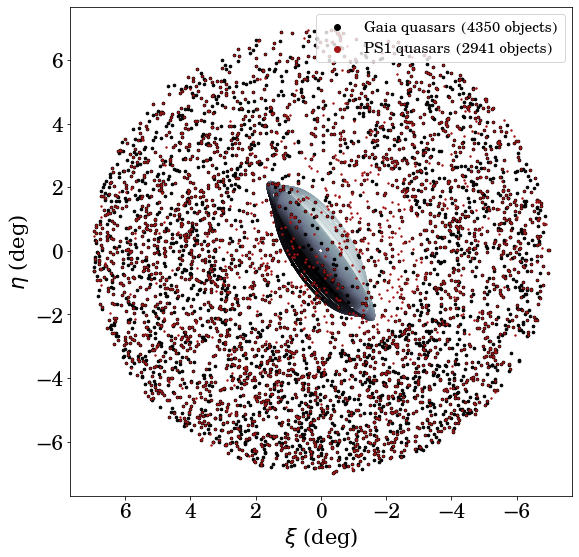

In [888]:
plt.figure(figsize=(9, 9))
#Plot the background:
plt.scatter(x_model, y_model, c=z_model, cmap=cmap, s=1, linewidth=0)

plt.scatter(evt_QSO_X_PS1['RAdeg'], evt_QSO_X_PS1['DECdeg'], c='#000000', 
            s=7, label=f"Gaia quasars ({len(evt_QSO_X_PS1['RAdeg'])} objects)")

plt.scatter(evt_PS1[maskProbaUpdated]['RAdeg'], evt_PS1[maskProbaUpdated]['DECdeg'], c='#A31515', 
            s=2, label=f"PS1 quasars ({len(evt_PS1[maskProbaUpdated]['RAdeg'])} objects)") 

plt.xlabel(r'$\xi$ (deg)', fontname = 'Serif', size = 21)
plt.ylabel(r'$\eta$ (deg)', fontname = 'Serif', size = 21)
plt.xticks(fontsize = 21)
plt.yticks(fontsize = 21)
plt.gca().invert_xaxis()
lgnd = plt.legend(loc="upper right", scatterpoints=1, fontsize=15)
lgnd.legendHandles[0]._sizes = [35]
lgnd.legendHandles[1]._sizes = [35]
#plt.savefig('Superimposed.png', dpi=500)
plt.show()

In the end it seems that this actually added quite a few quasars especially in the central region which is an awesomely great news for us. In order to inspect this aspect in more details we are going to make a cross-match those "new" object and the past ones in order to see which are actually the same and which aren't. To do so, we make use of the fact that the columns 'RAdeg' and 'DECdeg' are present in both 'evt_PS1' and in 'evt_QSO_X_PS1', so we are going to assume that when the cells for an object are commun they are not taken into account.

### Isolate the unmatched quasars

In [762]:
def Unmatch(A, N):
    a, n = np.array(A), np.array(N)
    Match = []
    hihi = 0

    for i in range(len(n)):
        Condition = False
        for j in range(len(a)):
            if n[i] == a[j]:
                Condition = True
                
        if Condition == False:
            Match.append(False)
            hihi += 1
        else:
            Match.append(True)
        
    return Match

In [763]:
maskMatch = (np.array(Unmatch(evt_QSO_X_PS1['RAdeg'], evt_PS1[maskProbaUpdated]['RAdeg'])) == False)

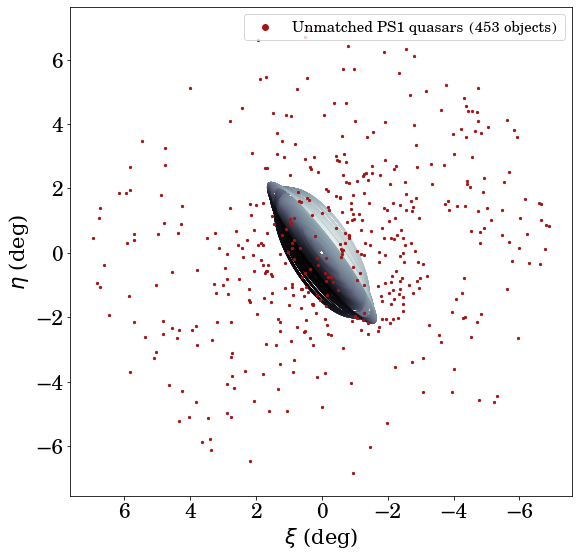

In [764]:
plt.figure(figsize=(9, 9))
#Plot the background:
plt.scatter(x_model, y_model, c=z_model, cmap=cmap, s=1, linewidth=0)
plt.scatter(evt_PS1[maskProbaUpdated][maskMatch]['RAdeg'], evt_PS1[maskProbaUpdated][maskMatch]['DECdeg'], c='#A31515', 
            s=5, label=f"Unmatched PS1 quasars ({len(evt_PS1[maskProbaUpdated][maskMatch]['DECdeg'])} objects)")
plt.xlabel(r'$\xi$ (deg)', fontname = 'Serif', size = 21)
plt.ylabel(r'$\eta$ (deg)', fontname = 'Serif', size = 21)
plt.xticks(fontsize = 21)
plt.yticks(fontsize = 21)
plt.gca().invert_xaxis()
lgnd = plt.legend(loc="upper right", scatterpoints=1, fontsize=15)
lgnd.legendHandles[0]._sizes = [35]
#plt.savefig('Superimposed.png', dpi=500)
plt.show()

Now what we are going to do is to use TopCat and hope that it can find matches between those and the Gaia catalogue. Just as a reminder, we now match those with Gaia in order to get the information about the proper motion of the objects which is obviously necessary in what we want to do.

In [766]:
choice1 = input("This will modify the table 'Added_QSOs_PS1', are you sure you want to do that? (Yes/No): ")

if choice1 == "Yes":
    Delta = 41.27*np.pi/180

    evt_PS1['RAdeg']  = (evt_PS1['RAdeg']/np.cos(Delta)) + 10.68
    evt_PS1['DECdeg'] = (evt_PS1['DECdeg'] + 41.27)

    evt_PS1[maskProbaUpdated][maskMatch].write('ThisIsTheData/Quasars/Added_QSOs_PS1.fits', 
                                               format='fits', overwrite=True)

This will modify the table 'Added_QSOs_PS1', are you sure you want to do that? (Yes/No): No


## Adding the new quasars

In [830]:
hdu_list = fits.open('ThisIsTheData/Quasars/Added_QSOs_GaiaDR3.fits', memmap=True)
hdu_list.info()
evt_added_QSOs = Table(hdu_list[1].data)

Delta = 41.27*np.pi/180

evt_added_QSOs['RAdeg']  = (evt_added_QSOs['RAdeg'] - 10.68)*np.cos(Delta)
evt_added_QSOs['DECdeg'] = (evt_added_QSOs['DECdeg'] - 41.27)

Filename: ThisIsTheData/Quasars/Added_QSOs_GaiaDR3.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      16   (1609,)   uint8   
  1  7xGaia DR3 (Epoch 2016)    1 BinTableHDU     45   448R x 10C   [D, D, E, D, E, D, E, D, E, E]   


In [915]:
display(evt_added_QSOs[0:1])
print('The new length of the table is', len(evt_added_QSOs))

RA_ICRS,DE_ICRS,p_QSO,Plx,e_Plx,pmRA,e_pmRA,pmDE,e_pmDE,pmRApmDEcor
float64,float64,float32,float64,float32,float64,float32,float64,float32,float32
-6.9095046103491455,0.8388712890336976,0.522,0.1233,0.3671,-0.62,0.364,-0.271,0.298,-0.1207


The new length of the table is 448


As we can see in the previous cell, this table is slightly smaller than before, this simply means that all the objects from PS1 couldn't have been found in the Gaia catalogue, but that really isn't a problem as long as those new quasars can actually help us (at least a bit). Now we are just going to stack those new quasars to the other ones we already had.

In [832]:
evt_added_QSOs['RAdeg'].name = 'RA_ICRS'
evt_added_QSOs['DECdeg'].name = 'DE_ICRS'

In [833]:
This_Might_Be_Good = vstack([evt_gaia, evt_added_QSOs])
maskNaN = (np.isnan(This_Might_Be_Good['RA_ICRS']) != True
          ) & (np.isnan(This_Might_Be_Good['RA_ICRS']) != True
          ) & (np.isnan(This_Might_Be_Good['DE_ICRS']) != True
          ) & (np.isnan(This_Might_Be_Good['pmRA']) != True
          ) & (np.isnan(This_Might_Be_Good['e_pmRA']) != True
          ) & (np.isnan(This_Might_Be_Good['pmDE']) != True
          ) & (np.isnan(This_Might_Be_Good['e_pmDE']) != True
          ) & (np.isnan(This_Might_Be_Good['pmRApmDEcor']) != True) 

In [834]:
RaDec1 = Quadrant(This_Might_Be_Good[maskNaN], 0)
RaDec2 = Quadrant(This_Might_Be_Good[maskNaN], 1)
RaDec3 = Quadrant(This_Might_Be_Good[maskNaN], 2)
RaDec4 = Quadrant(This_Might_Be_Good[maskNaN], 3)

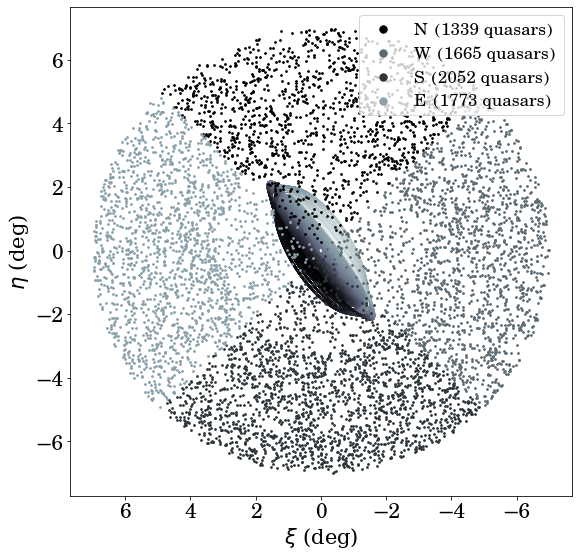

In [835]:
plt.figure(figsize=(9, 9))
plt.scatter(x_model, y_model, c=z_model, cmap=cmap, s=1, linewidth=0)
plt.scatter((RaDec2[0]), (RaDec2[1]), s=3, color='#000000', label=f"N ({len(RaDec2[0])} quasars)")
plt.scatter((RaDec1[0]), (RaDec1[1]), s=3, color='#5D6B72', label=f"W ({len(RaDec1[0])} quasars)")
plt.scatter((RaDec3[0]), (RaDec3[1]), s=3, color='#2E3639', label=f"S ({len(RaDec3[0])} quasars)")
plt.scatter((RaDec4[0]), (RaDec4[1]), s=3, color='#8BA1AB', label=f"E ({len(RaDec4[0])} quasars)")
plt.xlabel(r'$\xi$ (deg)', fontname = 'Serif', size = 21)
plt.ylabel(r'$\eta$ (deg)', fontname = 'Serif', size = 21)
plt.xticks(fontsize = 21)
plt.yticks(fontsize = 21)
plt.gca().invert_xaxis()
lgnd = plt.legend(loc="upper right", scatterpoints=1, fontsize=17)
lgnd.legendHandles[0]._sizes = [55]
lgnd.legendHandles[1]._sizes = [55]
lgnd.legendHandles[2]._sizes = [55]
lgnd.legendHandles[3]._sizes = [55]
plt.show()

Uncertainties in x:  5.909090909090892
Uncertainties in y:  5.454545454545439
Maximum of likelihood:


<IPython.core.display.Math object>

<IPython.core.display.Math object>

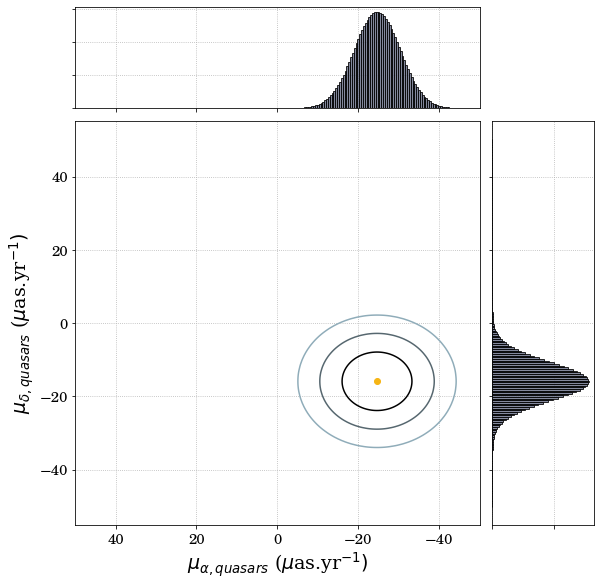

In [837]:
#Western quadrant::
ObjLike = LikelihooD(221, RaDec1)
Answer  = ObjLike.Execute()

Uncertainties in x:  5.909090909090892
Uncertainties in y:  5.909090909090892
Maximum of likelihood:


<IPython.core.display.Math object>

<IPython.core.display.Math object>

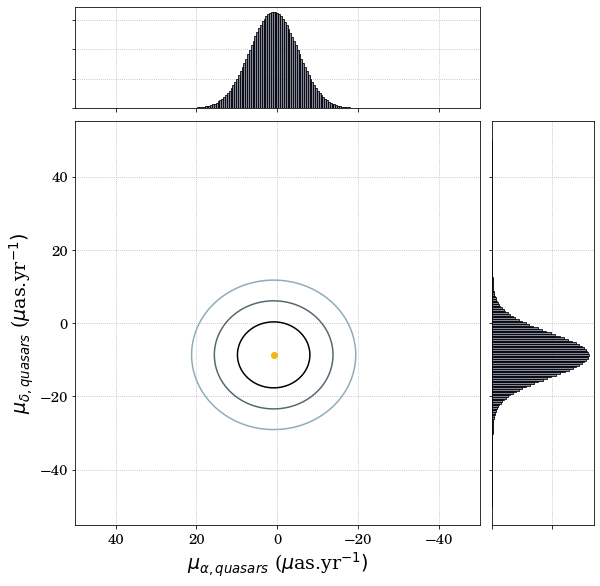

In [838]:
#Northern quadrant::
ObjLike = LikelihooD(221, RaDec2)
Answer  = ObjLike.Execute()

Uncertainties in x:  8.181818181818159
Uncertainties in y:  4.999999999999986
Maximum of likelihood:


<IPython.core.display.Math object>

<IPython.core.display.Math object>

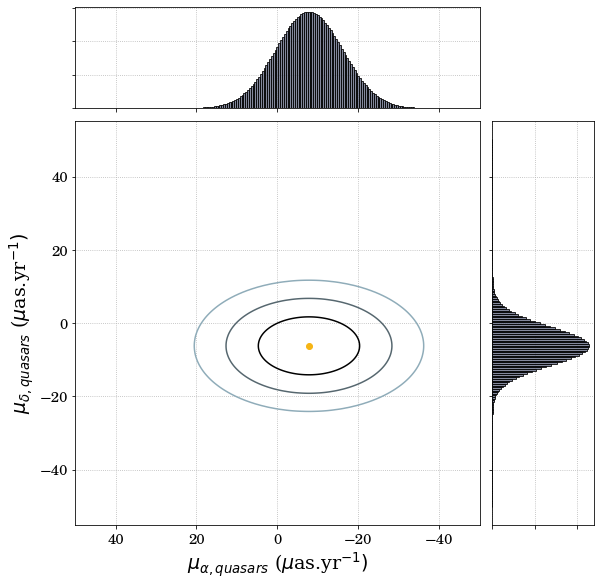

In [839]:
#Southern quadrant::
ObjLike = LikelihooD(221, RaDec3)
Answer  = ObjLike.Execute()

Uncertainties in x:  7.272727272727252
Uncertainties in y:  5.454545454545439
Maximum of likelihood:


<IPython.core.display.Math object>

<IPython.core.display.Math object>

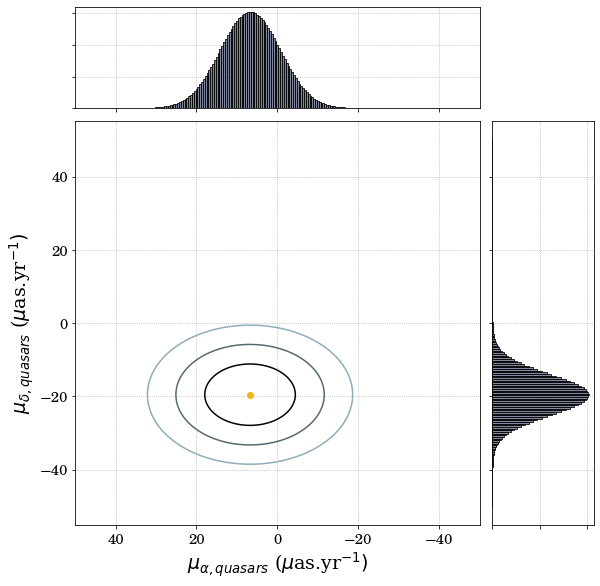

In [840]:
#Eastern quadrant::
ObjLike = LikelihooD(221, RaDec4)
Answer  = ObjLike.Execute()

## Using the new Gaia QSOs

The QSOs indicating as coming from Gaia since the beginning are actually not QSOs that have been identified from Gaia measurements but rather from past surveys. The position of those objects have then been associated to Gaia objects for a calibration. However, later, more QSOs have been identified this time thanks to the Gaia data themselves. They are here shown

In [910]:
hdu_list = fits.open('ThisIsTheData/Quasars/DR3_QSOs_Candidates.fits', memmap=True)
hdu_list.info()
new_QSOs = Table(hdu_list[1].data)
maskQSO = (new_QSOs['ASF'] == 1)
maskCRF = (new_QSOs['GCS'] == 1) #This row indicates which objects are also in the CRF

Delta = 41.27*np.pi/180

new_QSOs['RA_ICRS']  = (new_QSOs['RA_ICRS'] - 10.68)*np.cos(Delta)
new_QSOs['DE_ICRS'] = (new_QSOs['DE_ICRS'] - 41.27)

Filename: ThisIsTheData/Quasars/DR3_QSOs_Candidates.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      43   ()      
  1  I_356_qsocand    1 BinTableHDU     36   17626R x 4C   [B, B, D, D]   


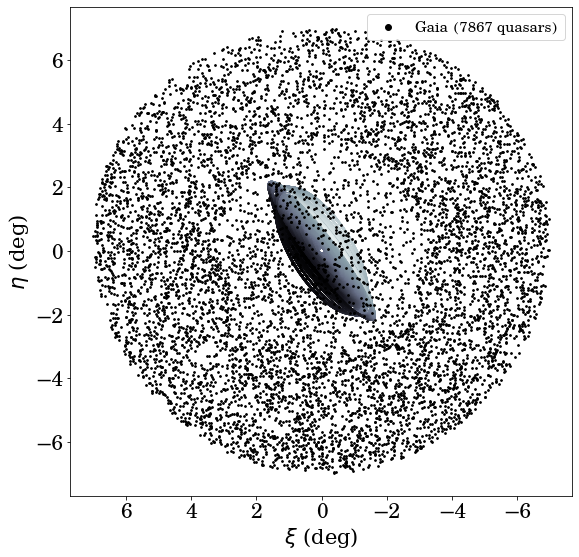

In [944]:
plt.figure(figsize=(9, 9))
#Plot the background:
plt.scatter(x_model, y_model, c=z_model, cmap=cmap, s=1, linewidth=0)
plt.scatter(new_QSOs[maskQSO]['RA_ICRS'], new_QSOs[maskQSO]['DE_ICRS'], c='black', s=3, 
            label=f"Gaia ({len(new_QSOs[maskQSO]['RA_ICRS'])} quasars)") #880808

plt.xlabel(r'$\xi$ (deg)', fontname = 'Serif', size = 21)
plt.ylabel(r'$\eta$ (deg)', fontname = 'Serif', size = 21)
lgnd = plt.legend(loc="upper right", scatterpoints=1, fontsize=15)
lgnd.legendHandles[0]._sizes = [35]
plt.xticks(fontsize = 21)
plt.yticks(fontsize = 21)
plt.gca().invert_xaxis()
#plt.savefig('Superimposed.png', dpi=500)
plt.show()

In [913]:
hdu_list = fits.open('ThisIsTheData/Quasars/Final_Non_Matching_QSOs.fits', memmap=True)
hdu_list.info()
PS1_Added_QSOs = Table(hdu_list[1].data)
PS1_Added_QSOs

Delta = 41.27*np.pi/180

PS1_Added_QSOs['RAdeg']  = (PS1_Added_QSOs['RAdeg'] - 10.68)*np.cos(Delta)
PS1_Added_QSOs['DECdeg'] = (PS1_Added_QSOs['DECdeg'] - 41.27)

Filename: ThisIsTheData/Quasars/Final_Non_Matching_QSOs.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      16   (2378,)   uint8   
  1  Joined        1 BinTableHDU     45   198R x 10C   [D, D, E, D, E, D, E, D, E, E]   


In [945]:
#Plot of the border circle:
t = np.linspace(0, 2*np.pi, 300)
x_circle = 7*np.cos(t)
y_circle = 7*np.sin(t)

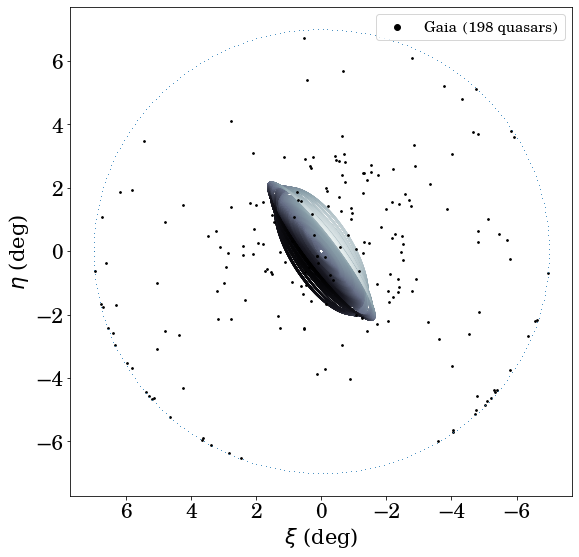

In [946]:
plt.figure(figsize=(9, 9))
#Plot the background:
plt.scatter(x_model, y_model, c=z_model, cmap=cmap, s=1, linewidth=0)
plt.scatter(PS1_Added_QSOs['RAdeg'], PS1_Added_QSOs['DECdeg'], c='black', s=3, 
            label=f"Gaia ({len(PS1_Added_QSOs['RAdeg'])} quasars)") #880808
plt.scatter(x_circle, y_circle, s=1, linewidth=0)

plt.xlabel(r'$\xi$ (deg)', fontname = 'Serif', size = 21)
plt.ylabel(r'$\eta$ (deg)', fontname = 'Serif', size = 21)
lgnd = plt.legend(loc="upper right", scatterpoints=1, fontsize=15)
lgnd.legendHandles[0]._sizes = [35]
plt.xticks(fontsize = 21)
plt.yticks(fontsize = 21)
plt.gca().invert_xaxis()
#plt.savefig('Superimposed.png', dpi=500)
plt.show()

As we can see at the bottom, some quasars are in the border, and I guess that this is due to the methods I used to make the selection of my objects. Indeed, on VizieR, I stated that I wanted a conesearch of 7° around M31, and I guess that it uses the whole precise trigonometry to do so while on the other hand I didn't, and I simply used the square of the cosinus which start to exhibit its imprecision in comparison to the full geometric treatement.

So I decided to apply a cut excluding al of these border quasars.

In [949]:
maskBorder = (PS1_Added_QSOs['RAdeg']*PS1_Added_QSOs['RAdeg'] + 
              PS1_Added_QSOs['DECdeg']*PS1_Added_QSOs['DECdeg'] < 47)

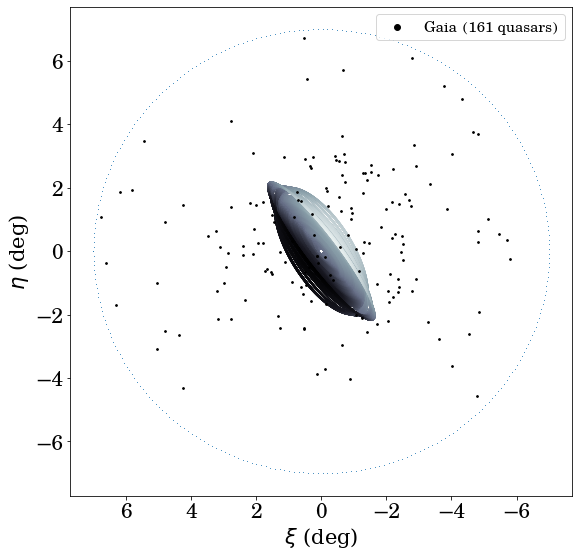

In [950]:
plt.figure(figsize=(9, 9))
#Plot the background:
plt.scatter(x_model, y_model, c=z_model, cmap=cmap, s=1, linewidth=0)
plt.scatter(PS1_Added_QSOs[maskBorder]['RAdeg'], PS1_Added_QSOs[maskBorder]['DECdeg'], c='black', s=3, 
            label=f"Gaia ({len(PS1_Added_QSOs[maskBorder]['RAdeg'])} quasars)") #880808
plt.scatter(x_circle, y_circle, s=1, linewidth=0)

plt.xlabel(r'$\xi$ (deg)', fontname = 'Serif', size = 21)
plt.ylabel(r'$\eta$ (deg)', fontname = 'Serif', size = 21)
lgnd = plt.legend(loc="upper right", scatterpoints=1, fontsize=15)
lgnd.legendHandles[0]._sizes = [35]
plt.xticks(fontsize = 21)
plt.yticks(fontsize = 21)
plt.gca().invert_xaxis()
#plt.savefig('Superimposed.png', dpi=500)
plt.show()

## Checking the QSOs from PS1

In this section we have crossed-matched the 250 QSOs from PS1 that we not corresponding to any QSOs in the Gaia CRF catalogue to objects from the Gaia EDR3. Once this is done we hence have all the information from Gaia associated to those objects, and what we will do is that we are going to apply the same selection rules that were applied by the Gaia Collaboration to select the quasar for the CRF catalogue.

### Valid parallax and proper motion

In [117]:
mask0 = (evt_ps1xgaiaNMInfo['astrometric_params_solved'] == 31) | (
        evt_ps1xgaiaNMInfo['astrometric_params_solved'] == 95)

In [118]:
print('Only remain', len(evt_ps1xgaiaNMInfo[mask0]), 'objects.')

Only remain 246 objects.


### Small to zero parallax

In [119]:
def CorrectPara(para, para_uncer):
    Result = []
    Para, Para_uncer = np.array(para), np.array(para_uncer)
    for i in range(len(Para)):
        if (abs((Para[i] + 0.017)/Para_uncer[i])) < 5:
            Result.append(True)
        else:
            Result.append(False)
            
    return Result

In [120]:
mask1 = (evt_ps1xgaiaNMInfo['astrometric_params_solved'] == 31) | (
        evt_ps1xgaiaNMInfo['astrometric_params_solved'] == 95) & (np.isnan(evt_ps1xgaiaNMInfo['parallax']) != True) & (
        np.isnan(evt_ps1xgaiaNMInfo['parallax_error']) != True) & (
        np.array(CorrectPara(evt_ps1xgaiaNMInfo['parallax'], evt_ps1xgaiaNMInfo['parallax_error'])) == True)

In [121]:
print('Only remain', len(evt_ps1xgaiaNMInfo[mask1]), 'objects.')

Only remain 246 objects.


### Proper motion

In [132]:
def CorrectProp(pmra, pmra_e, pmdec, pmdec_e, pm_corr):
    Result = []
    PMR, PMR_E, PMD = np.array(pmra), np.array(pmra_e), np.array(pmdec),
    PMD_E, PM_C = np.array(pmdec_e), np.array(pm_corr)
    
    for i in range(len(PMR)):
        A = np.power(PMR[i]/PMR_E[i], 2) + np.power(PMD[i]/PMD_E[i], 2)
        B = -2*(PMR[i]/PMR_E[i])*(PMD[i]/PMD_E[i])*PM_C[i]
        C = 1 - np.power(PM_C[i], 2)
        
        if (A + B)/C < 25:
            Result.append(True)
        else:
            Result.append(False)
            
    return Result

In [133]:
mask2 = (evt_ps1xgaiaNMInfo['astrometric_params_solved'] == 31) | (
        evt_ps1xgaiaNMInfo['astrometric_params_solved'] == 95) & (np.isnan(evt_ps1xgaiaNMInfo['parallax']) != True) & (
        np.isnan(evt_ps1xgaiaNMInfo['parallax_error']) != True) & (np.isnan(evt_ps1xgaiaNMInfo['pmRApmDEcor']) != True) & (
        np.isnan(evt_ps1xgaiaNMInfo['pmra']) != True) & (np.isnan(evt_ps1xgaiaNMInfo['pmra_error']) != True) & (
        np.isnan(evt_ps1xgaiaNMInfo['pmdec']) != True) & (np.isnan(evt_ps1xgaiaNMInfo['pmdec_error']) != True) & (
        np.array(CorrectPara(evt_ps1xgaiaNMInfo['parallax'], evt_ps1xgaiaNMInfo['parallax_error'])) == True) & (
        np.array(CorrectProp(evt_ps1xgaiaNMInfo['pmra'], evt_ps1xgaiaNMInfo['pmra_error'], evt_ps1xgaiaNMInfo['pmdec'],
                            evt_ps1xgaiaNMInfo['pmdec_error'], evt_ps1xgaiaNMInfo['pmRApmDEcor'])) == True) 

In [134]:
print('Only remain', len(evt_ps1xgaiaNMInfo[mask2]), 'objects.')

Only remain 243 objects.


### Galactic latitude

In [143]:
b_M31 = -21 #galactic latitude of M31
print(abs(np.sin(b_M31*np.pi/180)))

0.35836794954530027


We see that this the value of the $|\sin(b)|$ is indeed superior to 0.1, meaning that there isn't a problem caused by the fact that the QSOs could be mis-matched because being too close from the galactic plane.

In [166]:
%load_ext Cython

In [167]:
%%cython
from math import pi

cdef extern from "math.h":
    double log(double)

cdef double my_log(double x):
    return log(x)

def LikelihoodCFunction(double pm_ra_quasars, double pm_dec_quasars, double mu_ra_sig_gaia, 
                        double mu_dec_sig_gaia, double mu_ra_gaia, 
                        double mu_dec_gaia):
    cdef double PreFactor, ExpRa, ExpDec

    PreFactor = 1/(2*pi*mu_ra_sig_gaia*mu_dec_sig_gaia)    
    ExpRa  = -0.5*((mu_ra_gaia - pm_ra_quasars)/(mu_ra_sig_gaia))**2
    ExpDec = -0.5*((mu_dec_gaia - pm_dec_quasars)/(mu_dec_sig_gaia))**2
    
    return my_log(PreFactor) + ExpRa + ExpDec #exp to come back to the L and not ln(L)

def LikelihoodCFunctionCorr(double pm_ra_quasars, double pm_dec_quasars, double mu_ra_sig_gaia, 
                        double mu_dec_sig_gaia, double mu_ra_gaia, 
                        double mu_dec_gaia, double pm_corr):
    cdef double PreFactor, ExpRa, ExpDec, ExpCor

    PreFactor = 1/(2*pi*mu_ra_sig_gaia*mu_dec_sig_gaia*(1 - pm_corr**2)**(0.5))    
    ExpRa  = -(1/(2*(1 - pm_corr**2)))*((mu_ra_gaia - pm_ra_quasars)/(mu_ra_sig_gaia))**2
    ExpDec = -(1/(2*(1 - pm_corr**2)))*((mu_dec_gaia - pm_dec_quasars)/(mu_dec_sig_gaia))**2
    ExpCor =  (1/(2*(1 - pm_corr**2)))*((2*pm_corr*(mu_ra_gaia - pm_ra_quasars)*(
              mu_dec_gaia - pm_ra_quasars))/(mu_ra_sig_gaia*mu_dec_sig_gaia))
    
    return my_log(PreFactor) + ExpRa + ExpDec + ExpCor #exp to come back to the L and not ln(L)